In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import random

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)

dualanimals = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']

In [2]:
act_directory = "/Users/InsanallyLab/Desktop/Analysis_Cache"

In [3]:
animals_in_cache = []
EnumSession = []
EnumClust = []
EnumOnlySession = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
    
    if sessionfile.meta.animal not in dualanimals:
        continue
        
    if not sessionfile.meta.region == 'AC':
        continue
    

    EnumOnlySession.append(session)
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)
        
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 494/494 [01:40<00:00,  4.93it/s]


In [4]:
sessionfile.responsiveness[2]['all_trials'].FR - sessionfile.responsiveness[2]['all_trials'].FRbaseline

-1.099214846538187

In [5]:
sessionfile.responsiveness[2]['all_trials'].FR

2.569593147751606

In [6]:
sessionfile.responsiveness[2]['all_trials'].FRbaseline

3.668807994289793

In [7]:
animals_in_cache = []
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
# for session in tqdm(os.listdir(ops_directory)):
#     sessionfile = ilep.loadSessionCached(ops_directory,session)
#     animals_in_cache.append(sessionfile.meta.animal)
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
# for session in tqdm(os.listdir(ops_directory)):
#     sessionfile = ilep.loadSessionCached(ops_directory,session)
#     if sessionfile.meta.region != 'AC':
#         continue
#     training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
    
print(training_days_recorded['BS_59'])

100%|██████████| 494/494 [01:20<00:00,  6.11it/s]

[]


In [8]:
dualnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#animalnames = dualnames

#Animals missing:
#113,50,83,95
#Animals added:
#61,67,15,16,17,19,22

#animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
# opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214']
unuseddualanimals = ['BS_78']

animalnames = np.concatenate([dualanimalnames,tuninganimalnames,unuseddualanimals])

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#Dual Recording Animals
#animals['BS_33'].reversal = 20
animals['BS_67'].reversal = 7
#animals['BS_73'].reversal = np.nan
animals['BS_78'].reversal = np.nan
animals['BS_108'].reversal = 7
#animals['BS_113'].reversal = 13
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
#animals['BS_52'].reversal = 15
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
#animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
#animals['BS_83'].reversal = 20
#animals['BS_85'].reversal = 10
animals['BS_87'].reversal = 6
#animals['DS_16'].reversal = 11
#animals['BS_95'].reversal = 8
animals['DS_15'].reversal = 12
animals['DS_19'].reversal = 12

#Opsin Animals
# animals['BS_86'].reversal = 14
# animals['BS_92'].reversal = 9
# animals['BS_100'].reversal = 11
# animals['BS_103'].reversal = 8
# animals['BS_111'].reversal = 8
# animals['BS_119'].reversal = 10
# animals['BS_123'].reversal = 9
# animals['BS_128'].reversal = 6
# animals['BS_131'].reversal = 14
# animals['BS_139'].reversal = 10
# animals['BS_163'].reversal = 13
# animals['BS_165'].reversal = np.Inf
# animals['BS_174'].reversal = 14
# animals['BS_179'].reversal = 16
# animals['BS_191'].reversal = 10
# animals['BS_192'].reversal = 7

#Tuning Animals
animals['BS_173'].reversal = 15
animals['BS_175'].reversal = 11
animals['BS_187'].reversal = 8
animals['BS_188'].reversal = 8
animals['BS_213'].reversal = 8
animals['BS_214'].reversal = np.Inf

print([a for a in animals])

['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56', 'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108', 'DS_15', 'DS_19', 'BS_173', 'BS_175', 'BS_187', 'BS_188', 'BS_213', 'BS_214', 'BS_78']


BS_40
6
BS_41
3
BS_42
3
BS_49
2
BS_50
7
BS_51
6
BS_56
4
BS_59
3
BS_67
4
BS_70
5
BS_72
3
BS_87
4
BS_108
3
DS_15
7
DS_19
4
BS_173
2
BS_175
1
BS_187
4
BS_188
5
BS_213
6
BS_214
BS_214 has no post-reversal
inf
BS_78
BS_78 has no post-reversal
inf


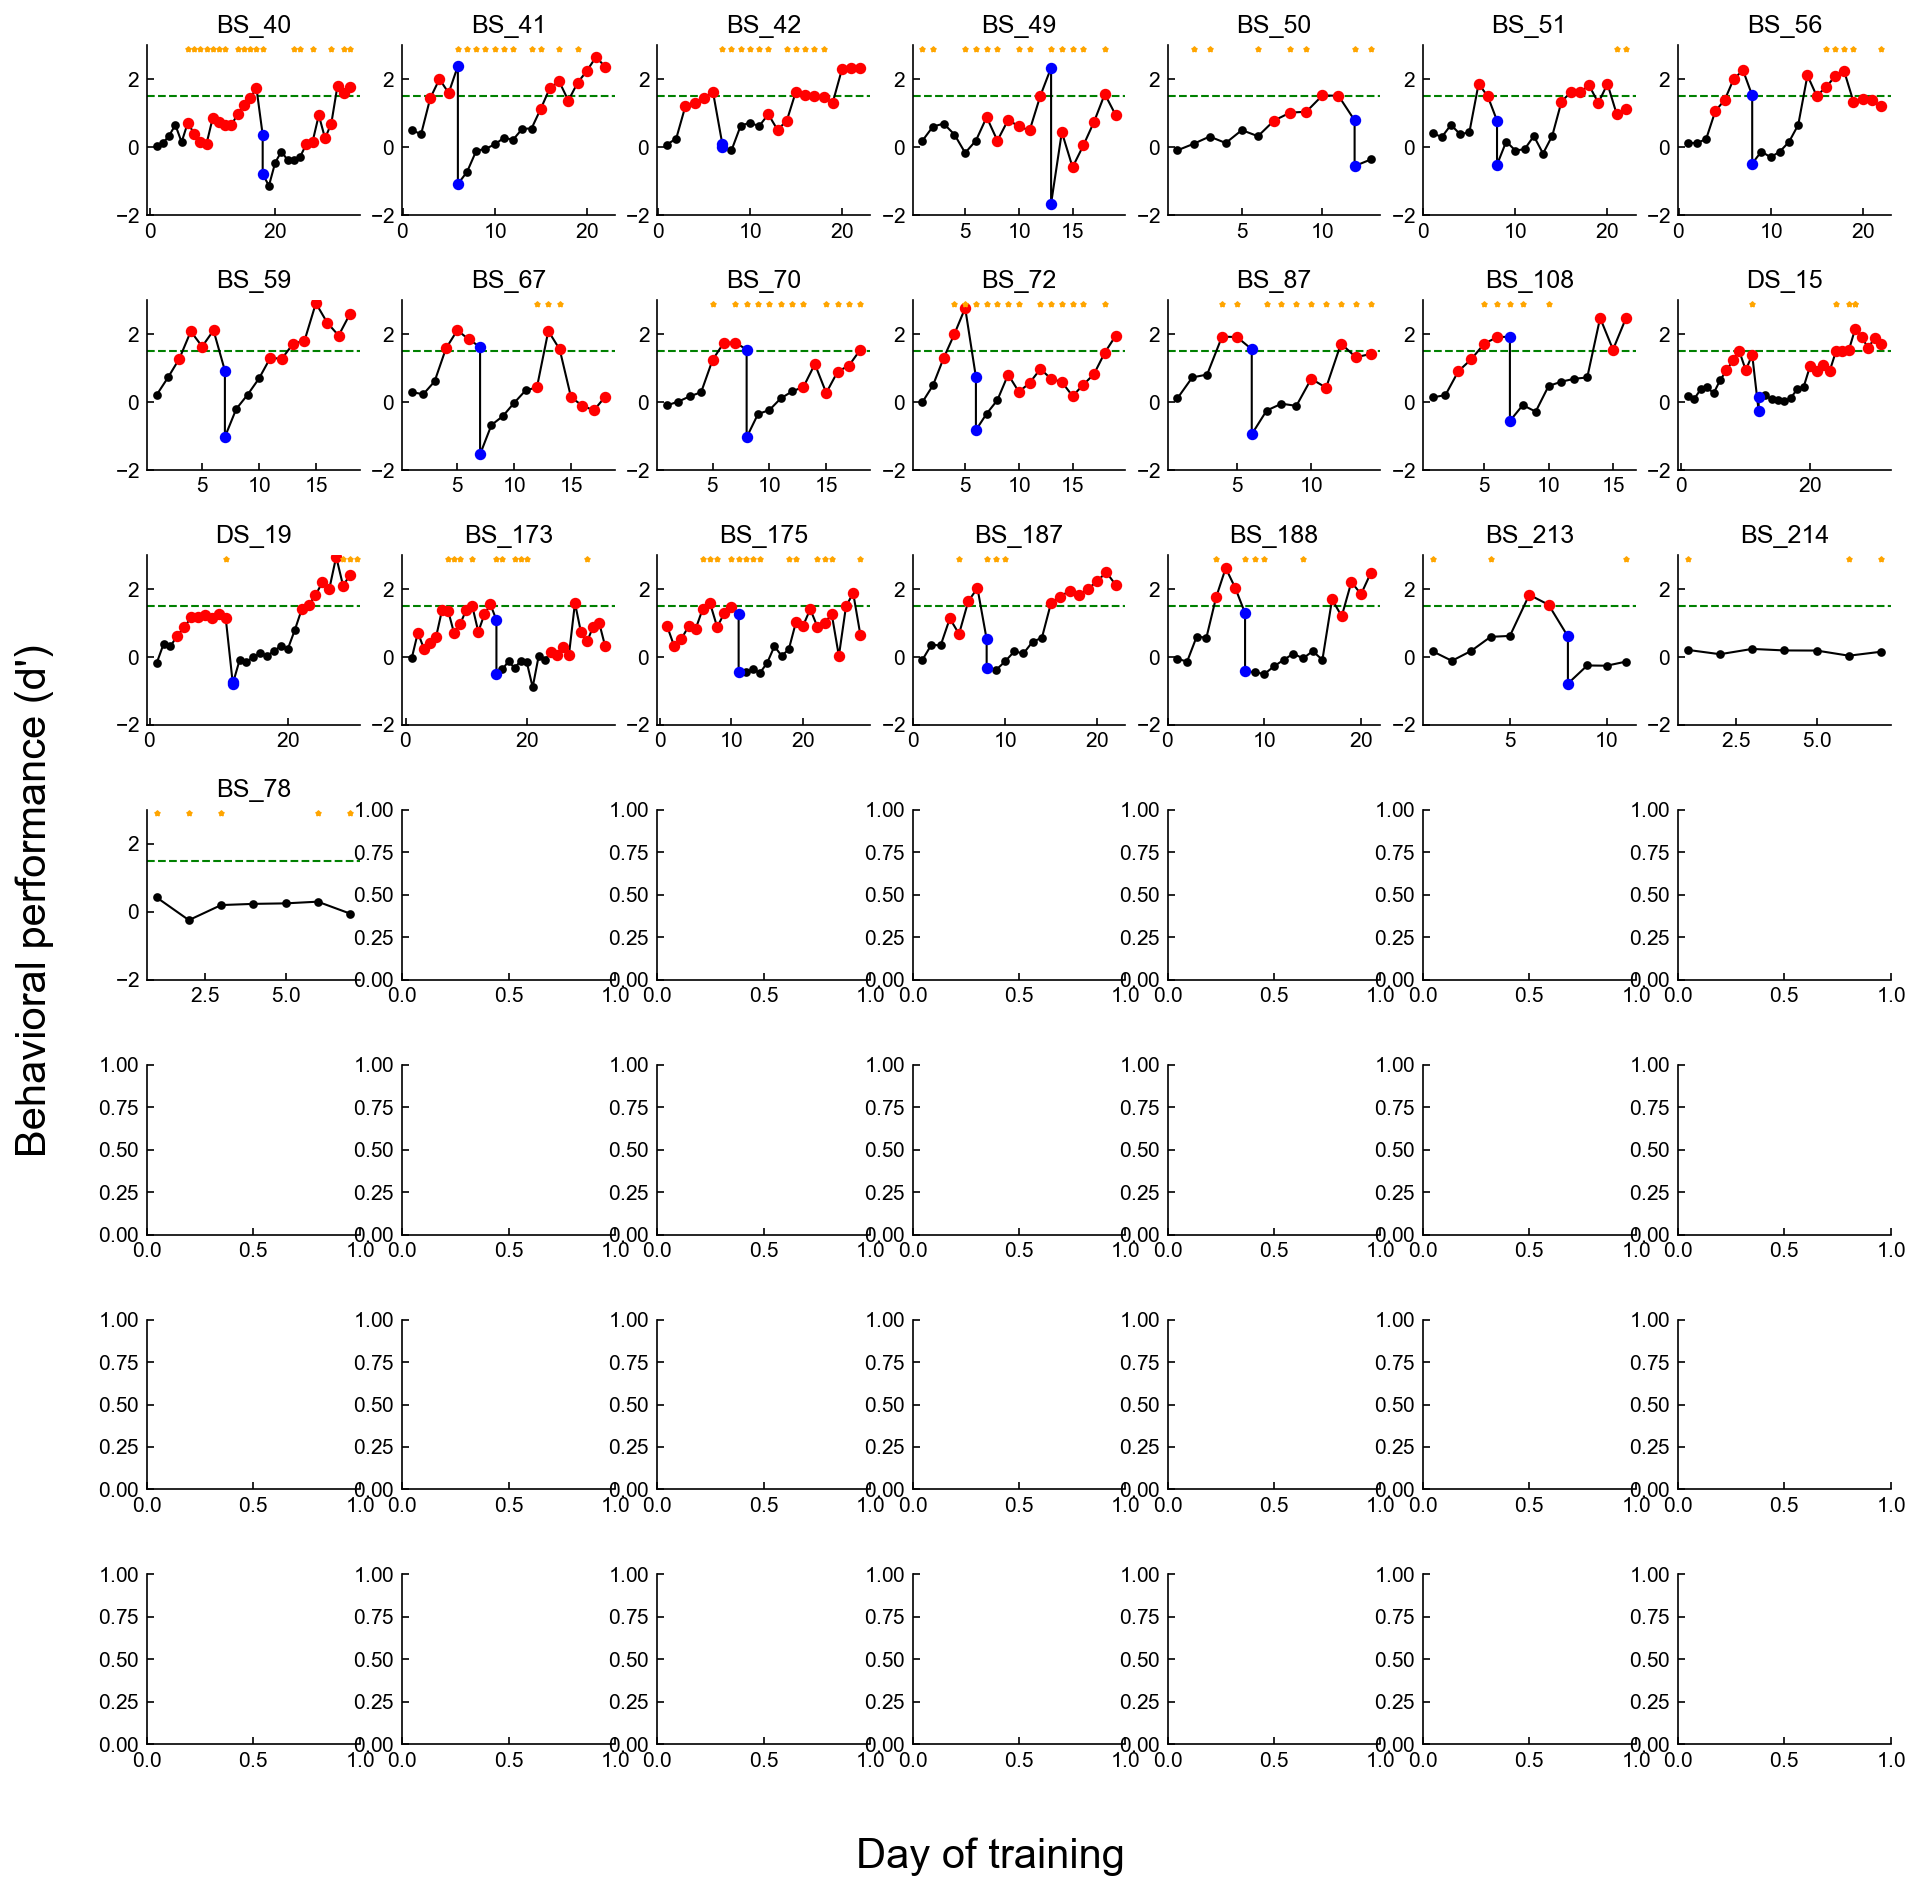

In [9]:
filename = os.path.join('/Users/InsanallyLab/Desktop/DataForJMTTotal.csv')
csv = pd.read_csv(filename)

postthresholds = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(7,7,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(7),range(7))]
    #plt.delaxes(axs[14])
    #plt.delaxes(axs[15])

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
PERphases = dict()

for animalidx,animal in enumerate(animals):
    print(animal)
    PERphases[animal] = dict()
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
            
        if day > animals[animal].reversal+1: #  +1 because the csv stores the switch day as two entries
            #Calculate PERphase
            PC = cond_pc[idx]
            if PC <= 47.5:
                PERphases[animal][day-1] = 'perseveration'
            elif PC >= 52.5:
                PERphases[animal][day-1] = 'refinement'
            else:
                PERphases[animal][day-1] = 'exploration'
            
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal or np.isnan(animals[animal].reversal):
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[1.5])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    try:
        maxperf = np.nanmax(np.concatenate((postreversaldps,[1.5])))
        minperf = np.nanmin(postreversaldps)
    except:
        print(animal+' has no post-reversal')
        maxperf = np.nan
        minperf = np.nan
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
        
    print(premiddlefirstday)
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal == 'BS_49':
        premiddlefirstday = 7
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday), np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    #plt.savefig(os.path.join('D:\\\\TempFigures','EIL Learning Phases.pdf'),transparent=False,facecolor="white")
    pass

In [10]:
EILphases = np.full_like(EnumOnlySession,np.nan)

for idx,session in enumerate(tqdm(EnumOnlySession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.condition=='prereversal naive' and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.condition=='prereversal expert':
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.condition=='postreversal naive' and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.condition=='postreversal expert':
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        #print(e)
        pass

100%|██████████| 142/142 [00:18<00:00,  7.89it/s]


In [11]:
print(np.unique(EILphases))

['nan' 'post early' 'post expert' 'post late' 'pre early' 'pre expert'
 'pre late' 'switch']


In [12]:
#each index is for each cell/cluster
#so length of EnumSession = EnumClust = EILphases

In [13]:
#Create learning phase array with sessions'index
pre_early = []
pre_late = []
pre_expert = []
post_early = []
post_late = []
post_expert = []

for idx,phase in enumerate(EILphases):
    if phase == 'pre early':
        pre_early.append(idx)
    if phase == 'pre late':
        pre_late.append(idx)
    if phase == 'pre expert':
        pre_expert.append(idx)
    if phase == 'post early':
        post_early.append(idx)
    if phase == 'post late':
        post_late.append(idx)
    if phase == 'post expert':
        post_expert.append(idx)

#create session file array for each learning phase
pre_early_session = []
pre_late_session = []
pre_expert_session = []
post_early_session = []
post_late_session = []
post_expert_session = []

for idx, session_idx in enumerate(pre_early):
    pre_early_session.append(ilep.loadSessionCached(act_directory,EnumOnlySession[session_idx]))
for idx, session_idx in enumerate(pre_late):
    pre_late_session.append(ilep.loadSessionCached(act_directory,EnumOnlySession[session_idx]))
for idx, session_idx in enumerate(pre_expert):
    pre_expert_session.append(ilep.loadSessionCached(act_directory,EnumOnlySession[session_idx]))
for idx, session_idx in enumerate(post_early):
    post_early_session.append(ilep.loadSessionCached(act_directory,EnumOnlySession[session_idx]))
for idx, session_idx in enumerate(post_late):
    post_late_session.append(ilep.loadSessionCached(act_directory,EnumOnlySession[session_idx]))
for idx, session_idx in enumerate(post_expert):
    post_expert_session.append(ilep.loadSessionCached(act_directory,EnumOnlySession[session_idx]))


In [14]:
#Sessions for each learning phase
pre_early = pre_early_session
pre_late= pre_late_session
pre_expert= pre_expert_session

post_early = post_early_session
post_late= post_late_session
post_expert= post_expert_session

print(len(pre_early))
print(len(pre_late))
print(len(pre_expert))
print(len(post_early))
print(len(post_late))
print(len(post_expert))

7
16
10
25
19
23


In [15]:
#classification criteria 
#FR-FRbase:
#NCR: FRmodulation < pre_early_baseline
#CR = not NCR
#CRevok: CR and (FR-FRbase)>0
#CRsup: CR and (FR-FRbase)<0

In [16]:
#calculate CRevok and CRsup percentage for each learning phase
FRmod_baseline = 3.59

def classify_CR(phase):
    CR_evok_num = 0
    CR_sup_num = 0
    
    #Need to find sessionfile object
    for sessionfile in phase:
        for clust in sessionfile.clusters.good: 
            if sessionfile.responsiveness[clust]['all_trials'].FRmodulation < FRmod_baseline:
                continue   
            response_diff = sessionfile.responsiveness[clust]['all_trials'].FR - sessionfile.responsiveness[clust]['all_trials'].FRbaseline
            #print(response_diff)
            if response_diff >0:
                CR_evok_num +=1
            if response_diff<0:
                CR_sup_num +=1
        
    CR_total = CR_evok_num + CR_sup_num
    CR_evok_per = CR_evok_num / CR_total
    CR_sup_per = CR_sup_num / CR_total
    
    return CR_evok_per, CR_sup_per
        
        

In [17]:
test_phase = pre_early[:]

In [18]:
#call functions for each learning phase
data_preearly = classify_CR(pre_early)
data_prelate = classify_CR(pre_late)
data_preexpert = classify_CR(pre_expert)
data_postearly = classify_CR(post_early)
data_postlate = classify_CR(post_late)
data_postexpert = classify_CR(post_expert)

In [19]:
#plot

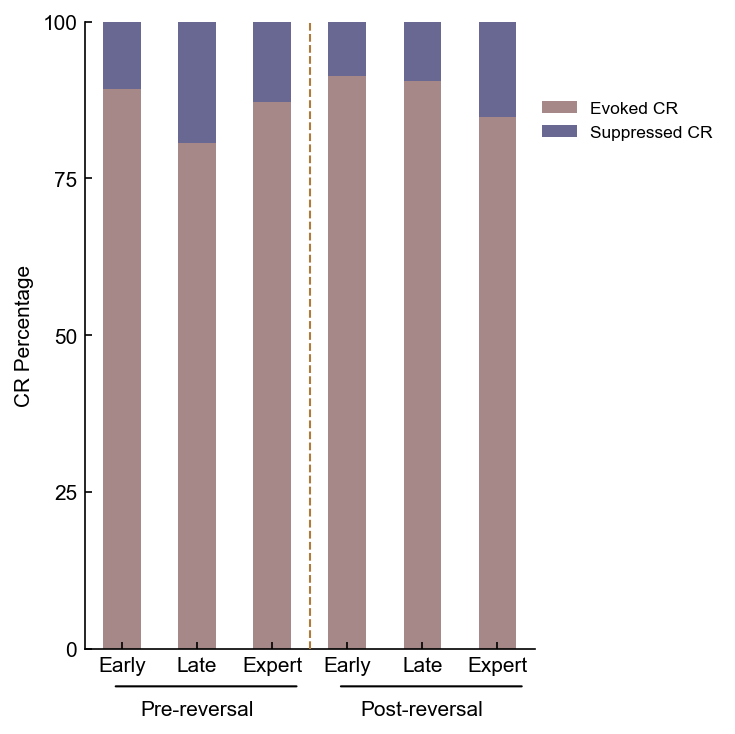

In [21]:
import matplotlib.lines as lines

size=5

fig,ax = plt.subplots(figsize=(5,5))

cells = ['Evoked CR', 'Suppressed CR', 'NCR', 'Inconclusive']

#data_learning_phase = ['Pre_Early','Pre_Late','Pre_Expert','Post_Early','Post_Late','Post_Expert']
data_learning_phase = ['Early','Late\n\nPre-reversal','Expert','Early','Late\n\nPost-reversal','Expert']

Evoked_CR = np.array([data_preearly[0],data_prelate[0],data_preexpert[0],data_postearly[0],data_postlate[0],data_postexpert[0]])
Sup_CR = np.array([data_preearly[1],data_prelate[1],data_preexpert[1],data_postearly[1],data_postlate[1],data_postexpert[1]])

#data
ax.bar(range(len(data_learning_phase)),Evoked_CR,label = 'Evoked CR',width = 0.5, color='#A78889')
ax.bar(range(len(data_learning_phase)),Sup_CR, bottom = Evoked_CR, label = 'Suppressed CR',width = 0.5,  color='#686893')

#Plot summary
ax.set_ylim([0,1])
ax.set_yticks([0,0.25,0.50,0.75,1])
ax.set_yticklabels(['0','25','50','75','100'])
ax.set_ylabel('CR Percentage')
ax.legend(frameon=False,loc=(1,0.8))

ax.set_xlim([-0.5,5.5])
ax.set_xlim(ax.get_xlim())
ax.set_xticks(range(len(data_learning_phase)))
ax.set_xticklabels(data_learning_phase)
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(2.5,color='r',linestyle='-')
ax.annotate('', xy=(0.06, -0.06), xycoords='axes fraction', xytext=(0.48, -0.06),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.56, -0.06), xycoords='axes fraction', xytext=(0.98, -0.06),arrowprops=dict(arrowstyle='-', color='black'))
#plt.figtext(0.2, -0.01, 'Pre-reversal', wrap=True, horizontalalignment='left')
#plt.figtext(0.5, -0.01, 'Post-reversal', wrap=True, horizontalalignment='left')

plt.tight_layout()
fig.savefig(os.path.join('/Users/InsanallyLab/Desktop/Tiange Mac Folder/Figures','CR learning phase percentage.pdf'),transparent=False,facecolor="white")

In [ ]:
raise NotImplementedError("not use")